下载模型文件

In [43]:
from datasets import dataset_utils
import tensorflow as tf

# url = "http://download.tensorflow.org/models/mobilenet_v1_0.50_128_2017_06_14.tar.gz"
url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
# 指定保存路径
checkpoints_dir = '/notebooks/test/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)


>> Downloading vgg_16_2016_08_28.tar.gz 100.0%
Successfully downloaded vgg_16_2016_08_28.tar.gz 513324920 bytes.


在python中import datasets需要先下载models

In [32]:
ls /notebooks/test/checkpoints/mobilenet_v1_0.50_128_2017_06_14/

mobilenet_v1_0.50_128_2017_06_14/


import sys
import os


sys.path.append("/notebooks/test/models/slim")

下面使用预训练好的模型进行图像分类

In [8]:
%matplotlib inline

import sys
import os


sys.path.append("/root/code/tensorflow/models/slim")

from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import vgg
from nets import mobilenet_v1
from preprocessing import vgg_preprocessing
from preprocessing import mobilenet_preprocessing

INFO:tensorflow:Restoring parameters from /root/code/tensorflow/checkpoints/vgg_16.ckpt


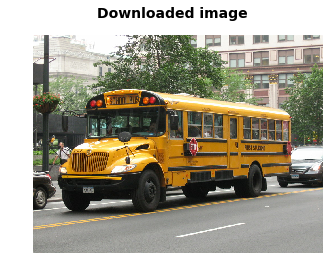

Probability 1.00 => [school bus]
Probability 0.00 => [minibus]
Probability 0.00 => [passenger car, coach, carriage]
Probability 0.00 => [trolleybus, trolley coach, trackless trolley]
Probability 0.00 => [cab, hack, taxi, taxicab]


In [14]:
%matplotlib inline

from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
import urllib2

from datasets import imagenet
from nets import vgg
from nets import mobilenet_v1

from preprocessing import vgg_preprocessing

#checkpoints_dir = '/notebooks/test/checkpoints/'
checkpoints_dir = '/root/code/tensorflow/checkpoints/'
slim = tf.contrib.slim

# We need default size of image for a particular network.
# The network was trained on images of that size -- so we
# resize input image later in the code.
image_size = vgg.vgg_16.default_image_size
#image_size = mobilenet_v1.mobilenet_v1.default_image_size

with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/First_Student_IC_school_bus_202076.jpg")

    
    # Open specified url and load image as a string
    image_string = urllib2.urlopen(url).read()
    
    # Decode string into matrix with intensity values
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Resize the input image, preserving the aspect ratio
    # and make a central crop of the resulted image.
    # The crop will be of the size of the default image size of
    # the network.
    processed_image = vgg_preprocessing.preprocess_image(image,
                                                        image_size,
                                                        image_size,
                                                        is_training=False)
#     processed_image = mobilenet_preprocessing.preprocess_image(image,
#                                                          image_size,
#                                                          image_size,
#                                                          is_training=False)
    # Networks accept images in batches.
    # The first dimension usually represents the batch size.
    # In our case the batch size is one.
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure
    # the batch norm parameters. arg_scope is a very conveniet
    # feature of slim library -- you can define default
    # parameters for layers -- like stride, padding etc.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images,
                               num_classes=1000,
                               is_training=False)
#     with slim.arg_scope(mobilenet_v1.mobilenet_v1_arg_scope):
#         logits, _ = mobilenet_v1.mobilenet_v1(processed_images,
#                                num_classes=1000,
#                                is_training=False)
    # In order to get probabilities we apply softmax on the output.
    probabilities = tf.nn.softmax(logits)
    
    # Create a function that reads the network weights
    # from the checkpoint file that you downloaded.
    # We will run it in session later.
#     init_fn = slim.assign_from_checkpoint_fn(
#         os.path.join(checkpoints_dir, 'mobilenet_v1_0.50_128.ckpt.meta'),
#         slim.get_model_variables('mobilenet_v1_0.50_128'))

# with tf.Session() as sess:
#     saver = tf.train.import_meta_graph('models/my-model.meta')
#     saver.restore(sess, tf.train.latest_checkpoint('models/'))
#     outputTensors = sess.run(outputOps, feed_dict=feedDict)

    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
#     plt.figure()
#     plt.imshow(np_image.astype(np.uint8))
#     plt.axis('off')
#     plt.show()

#     names = imagenet.create_readable_names_for_imagenet_labels()
#     for i in range(5):
#         index = sorted_inds[i]
#         print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))



    #with tf.Session() as sess:
#     with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:    
#         # Load weights
#         #init_fn(sess)
#         saver = tf.train.import_meta_graph(checkpoints_dir+"mobilenet_v1_1.0_224.ckpt.meta")
#         saver.restore(sess, tf.train.latest_checkpoint(checkpoints_dir))

#         # We want to get predictions, image as numpy matrix
#         # and resized and cropped piece that is actually
#         # being fed to the network.
#         np_image, network_input, probabilities = sess.run([image,
#                                                            processed_image,
#                                                            probabilities])
#         probabilities = probabilities[0, 0:]
#         sorted_inds = [i[0] for i in sorted(enumerate(-probabilities),
#                                             key=lambda x:x[1])]
    
    # Show the downloaded image
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.suptitle("Downloaded image", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    # Show the image that is actually being fed to the network
    # The image was resized while preserving aspect ratio and then
    # cropped. After that, the mean pixel value was subtracted from
    # each pixel of that crop. We normalize the image to be between [-1, 1]
    # to show the image.
#     plt.imshow( network_input / (network_input.max() - network_input.min()) )
#     plt.suptitle("Resized, Cropped and Mean-Centered input to the network",
#                  fontsize=14, fontweight='bold')
#     plt.axis('off')
#     plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Now we print the top-5 predictions that the network gives us with
        # corresponding probabilities. Pay attention that the index with
        # class names is shifted by 1 -- this is because some networks
        # were trained on 1000 classes and others on 1001. VGG-16 was trained
        # on 1000 classes.
        print('Probability %0.2f => [%s]' % (probabilities[index], names[index+1]))
        
    res = slim.get_model_variables()

In [15]:
slim.get_model_variables()

[]

In [40]:
ls /notebooks/test/checkpoints/

mobilenet_v1_0.50_128.ckpt.data-00000-of-00001
mobilenet_v1_0.50_128.ckpt.index
mobilenet_v1_0.50_128.ckpt.meta
mobilenet_v1_0.50_128_2017_06_14/
mobilenet_v1_0.50_128_2017_06_14.tar.gz


In [49]:
os.path.join(checkpoints_dir, 'vgg_16.ckpt')

'/notebooks/test/checkpoints/vgg_16.ckpt'

In [50]:
slim.get_model_variables()

[]

In [54]:
ls checkpoints

First_Student_IC_school_bus_202076.jpg
mobilenet_v1_0.50_128.ckpt
mobilenet_v1_0.50_128.ckpt.data-00000-of-00001
mobilenet_v1_0.50_128.ckpt.index
mobilenet_v1_0.50_128.ckpt.meta
mobilenet_v1_0.50_128_2017_06_14/
mobilenet_v1_0.50_128_2017_06_14.tar.gz
vgg_16.ckpt
vgg_16_2016_08_28.tar.gz
